In [ ]:
!pip uninstall numpy matplotlib -y
!pip install --force-reinstall --no-deps matplotlib==3.8.2
!pip install numpy matplotlib

In [1]:
import wandb
import matplotlib.pyplot as plt
import matplotlib as mpl
import os

In [2]:
# Render plots in LaTeX
plt.rc('text', usetex = True)
plt.rc('font', family = 'serif')

In [3]:
def get_data(pde_name, pde_params, metrics, extension, entity_name):
    proj_name = f'{pde_name}_{extension}'
    data = {}

    api = wandb.Api()
    best_l2re = float('inf')
    best_run = None
    for run in api.runs(f'{entity_name}/{proj_name}'):
        if run.state != 'finished':
            continue

        config = run.config
        if config['pde_params'] != pde_params:
            continue

        l2re = run.summary["test/l2re"]
        if l2re < best_l2re:
            best_l2re = l2re
            best_run = run

    # Adjust indices based on the optimizer extension
    if 'nncg' in extension:
        adam_index, final_index = 6, 8
    elif 'gd' in extension:
        adam_index, final_index = 5, 7

    adam_to_lbfgs_iter = int(best_run.config['opt_params'][adam_index])
    lbfgs_to_final_iter = int(best_run.config['opt_params'][final_index])

    lbfgs_to_final_iter = int(lbfgs_to_final_iter - adam_to_lbfgs_iter) + int(adam_to_lbfgs_iter / 20)
    adam_to_lbfgs_iter = int(adam_to_lbfgs_iter / 20)

    for metric in metrics:
        data[metric] = best_run.history(samples=int(1e6), keys=[metric], pandas=False)
        data[metric] = [dict[metric] for dict in data[metric]]

        # Include optimizer switch points in data
        data[f'{metric}_switches'] = [adam_to_lbfgs_iter, lbfgs_to_final_iter]

    return data

In [4]:
def get_title(pde_name, pde_params):
    if pde_name == "convection":
        return f'Convection, $\\beta = {pde_params[1]}$'
    elif pde_name == "reaction":
        return f'Reaction, $\\rho = {pde_params[1]}$'
    elif pde_name == "wave":
        return f'Wave, $\\beta = {pde_params[1]}$'

In [9]:
def plot_under_optimize_multi_pde(pdes, metrics, extensions, entity_name, metric_names, opt_colors, font_size, folder_path, filename):
    mpl.rcParams.update({'font.size': font_size})

    nrows = len(metrics)
    ncols = len(pdes)

    fig, axs = plt.subplots(nrows, ncols, figsize=(ncols * 5, nrows * 4))

    for col, (pde_name, pde_params) in enumerate(pdes):
        data_list = [get_data(pde_name, pde_params, metrics, ext, entity_name) for ext in extensions]

        for row, metric in enumerate(metrics):
            if nrows > 1 and ncols > 1:
                ax = axs[row, col]
            elif nrows > 1 or ncols > 1:
                if nrows == 1:
                    ax = axs[col]
                else:
                    ax = axs[row]
            else:
                ax = axs

            for data, extension in zip(data_list, extensions):
                switches = data[f'{metric}_switches']
                adam_to_lbfgs_iter, lbfgs_to_final_iter = switches
                ax.plot(data[metric][:adam_to_lbfgs_iter], color=opt_colors['adam'], linestyle='solid')
                ax.plot(range(adam_to_lbfgs_iter, lbfgs_to_final_iter), data[metric][adam_to_lbfgs_iter:lbfgs_to_final_iter], color=opt_colors['lbfgs'], linestyle='solid')
                ax.plot(range(lbfgs_to_final_iter, len(data[metric])), data[metric][lbfgs_to_final_iter:], color=opt_colors[extension.split('_')[-2]], linestyle='dashed')

            ax.set_title(get_title(pde_name, pde_params))
            ax.set_xlabel('Iterations / 20')
            ax.set_ylabel(metric_names[metric])
            ax.set_yscale('log')

    # Manually define legend
    nncg_exists = False
    gd_exists = False
    for extension in extensions:
        if 'nncg' in extension:
            nncg_exists = True
        elif 'gd' in extension:
            gd_exists = True

    legend_elements = [
        plt.Line2D([0], [0], color=opt_colors['adam'], label='Adam'),
        plt.Line2D([0], [0], color=opt_colors['lbfgs'], label='L-BFGS')
    ]
    if nncg_exists:
        legend_elements.append(plt.Line2D([0], [0], color=opt_colors['nncg'], linestyle='dashed', label='NNCG'))
    if gd_exists:
        legend_elements.append(plt.Line2D([0], [0], color=opt_colors['gd'], linestyle='dashed', label='GD'))

    fig.legend(handles=legend_elements, loc='lower center', bbox_to_anchor=(0.5, -0.05), ncol=4)

    fig.tight_layout(rect=[0, 0.03, 1, 0.95])

    if not os.path.exists(folder_path):
        os.makedirs(folder_path)

    filename = filename + '.pdf'
    fig.savefig(os.path.join(folder_path, filename), bbox_inches='tight')
    plt.show()

In [10]:
entity_name = 'sketchy-opts'
extension = 'adam_lbfgs_nncg_best'
opt_colors = {
    'adam': 'tab:blue',
    'lbfgs': 'tab:orange',
    'nncg': 'tab:pink',
    'gd': 'black'  # GD optimizer color
}
metric_names = {
    'loss': 'Loss',
    'grad_norm': 'Gradient Norm'
}

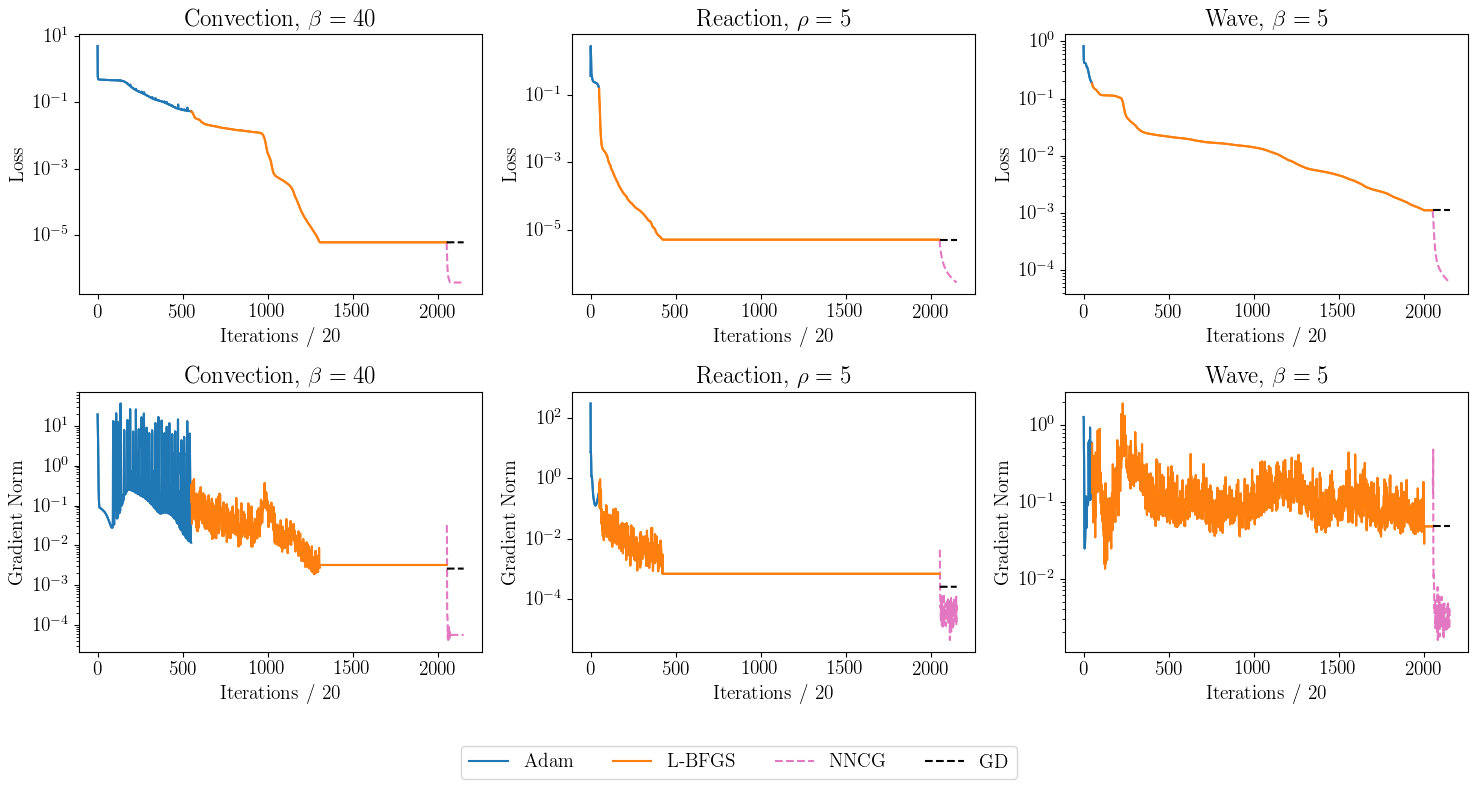

In [11]:
pdes = [('convection', ['beta', '40']), ('reaction', ['rho', '5']), ('wave', ['beta', '5'])]
metrics = ['loss', 'grad_norm']
extensions = ['adam_lbfgs_nncg_best', 'adam_lbfgs_gd_best']

folder_path = 'under_optimization_plots'
filename = 'under_optimization'

plot_under_optimize_multi_pde(pdes, metrics, extensions, entity_name, metric_names, opt_colors,
                                font_size=14, folder_path=folder_path, filename=filename)

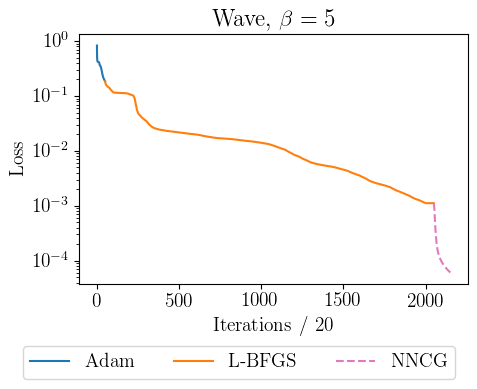

In [12]:
pdes = [('wave', ['beta', '5'])]
metrics = ['loss']
extensions = ['adam_lbfgs_nncg_best']

folder_path = 'under_optimization_plots'
filename = 'under_optimization_intro'

plot_under_optimize_multi_pde(pdes, metrics, extensions, entity_name, metric_names, opt_colors,
                                font_size=14, folder_path=folder_path, filename=filename)